Before running the code blocks, run the following commands to get the kernel prepared:
```sh
julia
import Pkg
Pkg.update()
Pkg.precompile()

using Pkg
Pkg.build("IJulia")
```

In [4]:
using HDF5
using Serialization
using DataFrames, Plots, Statistics
using Plots.PlotMeasures 

In [8]:
function timer_dict_to_df(timer_dict)
    rows = []

    for (trial, ranks) in timer_dict
        println("Processing trial: $trial")
        n_important_prt, total_rank, nprt_per_rank, n_float_per_particle, perm = split(trial, ":")
        n_important_prt = n_important_prt == "half" ? "50%" : n_important_prt
        trial_name = "$n_important_prt particles"
        for (rank, timers) in ranks
            for (op, metrics) in timers["inner_timers"]
                # Flatten inner timers for receive loop
                if op == "receive loop"
                    for (inner_op, inner_metrics) in metrics["inner_timers"]
                        for (metric, value) in inner_metrics
                            if metric == "time_ns"
                                value = value / 1e3 # Convert nanoseconds to microseconds
                                metric = "time_micros"
                            end
                            push!(rows, (
                                trial  = String(trial_name),
                                perm = String(perm),
                                total_rank = parse(Int, total_rank),
                                particle_size = n_float_per_particle,
                                nprt_per_rank = nprt_per_rank,
                                rank   = string(rank),
                                op     = String(inner_op),
                                metric = String(metric),
                                value  = value,
                            ))
                        end
                    end
                end
                for (metric, value) in metrics
                    if metric == "inner_timers"
                        continue # Skip the inner_timers key
                    end
                    if metric == "time_ns"
                        value = value / 1e3 # Convert nanoseconds to microseconds
                        metric = "time_micros"
                    end
                    push!(rows, (
                        trial  = String(trial_name),
                        perm = String(perm),
                        total_rank = parse(Int, total_rank),
                        particle_size = n_float_per_particle,
                        nprt_per_rank = nprt_per_rank,
                        rank   = string(rank),
                        op     = String(op),
                        metric = String(metric),
                        value  = value,
                    ))
                end
            end
        end
    end
    return DataFrame(rows)
end

timer_dict_to_df (generic function with 1 method)

In [6]:
function render(df, label=false)
  trials = unique(df.trial)
  ops    = unique(df.op)

  ntrials, nops = length(trials), length(ops)

  # 2) Create an empty grid, with row & column titles
  plt = plot(
    layout     = (ntrials, nops),
    legend = label ? :topleft : :none,
    size       = (300 * nops, 300 * ntrials),
  )

  # 3) Fill it in
  for (i, trial) in enumerate(trials)
    for (j, op) in enumerate(ops)
      sub = df[(df.trial .== trial) .& (df.op .== op), :]
      for rk in unique(sub.rank)
        subrk = sub[sub.rank .== rk, :]
        scatter!(
          plt[i, j],
          string.(subrk.total_rank),    # categorical x
          subrk.time_micros;
          marker     = :circle,
          markersize = 4,
          label      = rk,
          right_margin = 10mm,
          color      = rk == "0" ? :blue : :orange,
        )
      end
      plot!(plt[i, j], title = string(op), top_margin = 10mm)
      if j == 1
        plot!(plt[i, j], ylabel = string(trial), left_margin = 20mm)
      end

      # only the bottom row gets the shared x‐axis label
      if i == ntrials
        plot!(plt[i, j], xlabel = "Total Rank")
      end
    end
  end

  display(plt)
  return plt
end

render (generic function with 2 methods)

Processing trial: 100:1:1000:100000:randperm
Processing trial: 1:1:1000:100000:randperm
Processing trial: half:1:1000:100000:randperm
Processing trial: all:1:1000:100000:firstperm
Processing trial: 10:1:1000:100000:randperm
Processing trial: all:1:1000:100000:randperm
Processing trial: 1:1:1000:100000:firstperm
Processing trial: 100:1:1000:100000:firstperm
Processing trial: 10:1:1000:100000:firstperm
Processing trial: half:1:1000:100000:firstperm
Processing trial: 100:2:1000:100000:randperm
Processing trial: 10:2:1000:100000:firstperm
Processing trial: half:2:1000:100000:randperm
Processing trial: all:2:1000:100000:firstperm
Processing trial: 1:2:1000:100000:randperm
Processing trial: 1:2:1000:100000:firstperm
Processing trial: 100:2:1000:100000:firstperm
Processing trial: half:2:1000:100000:firstperm
Processing trial: 10:2:1000:100000:randperm
Processing trial: all:2:1000:100000:randperm
Processing trial: 100:4:1000:100000:randperm
Processing trial: 10:4:1000:100000:randperm
Processin

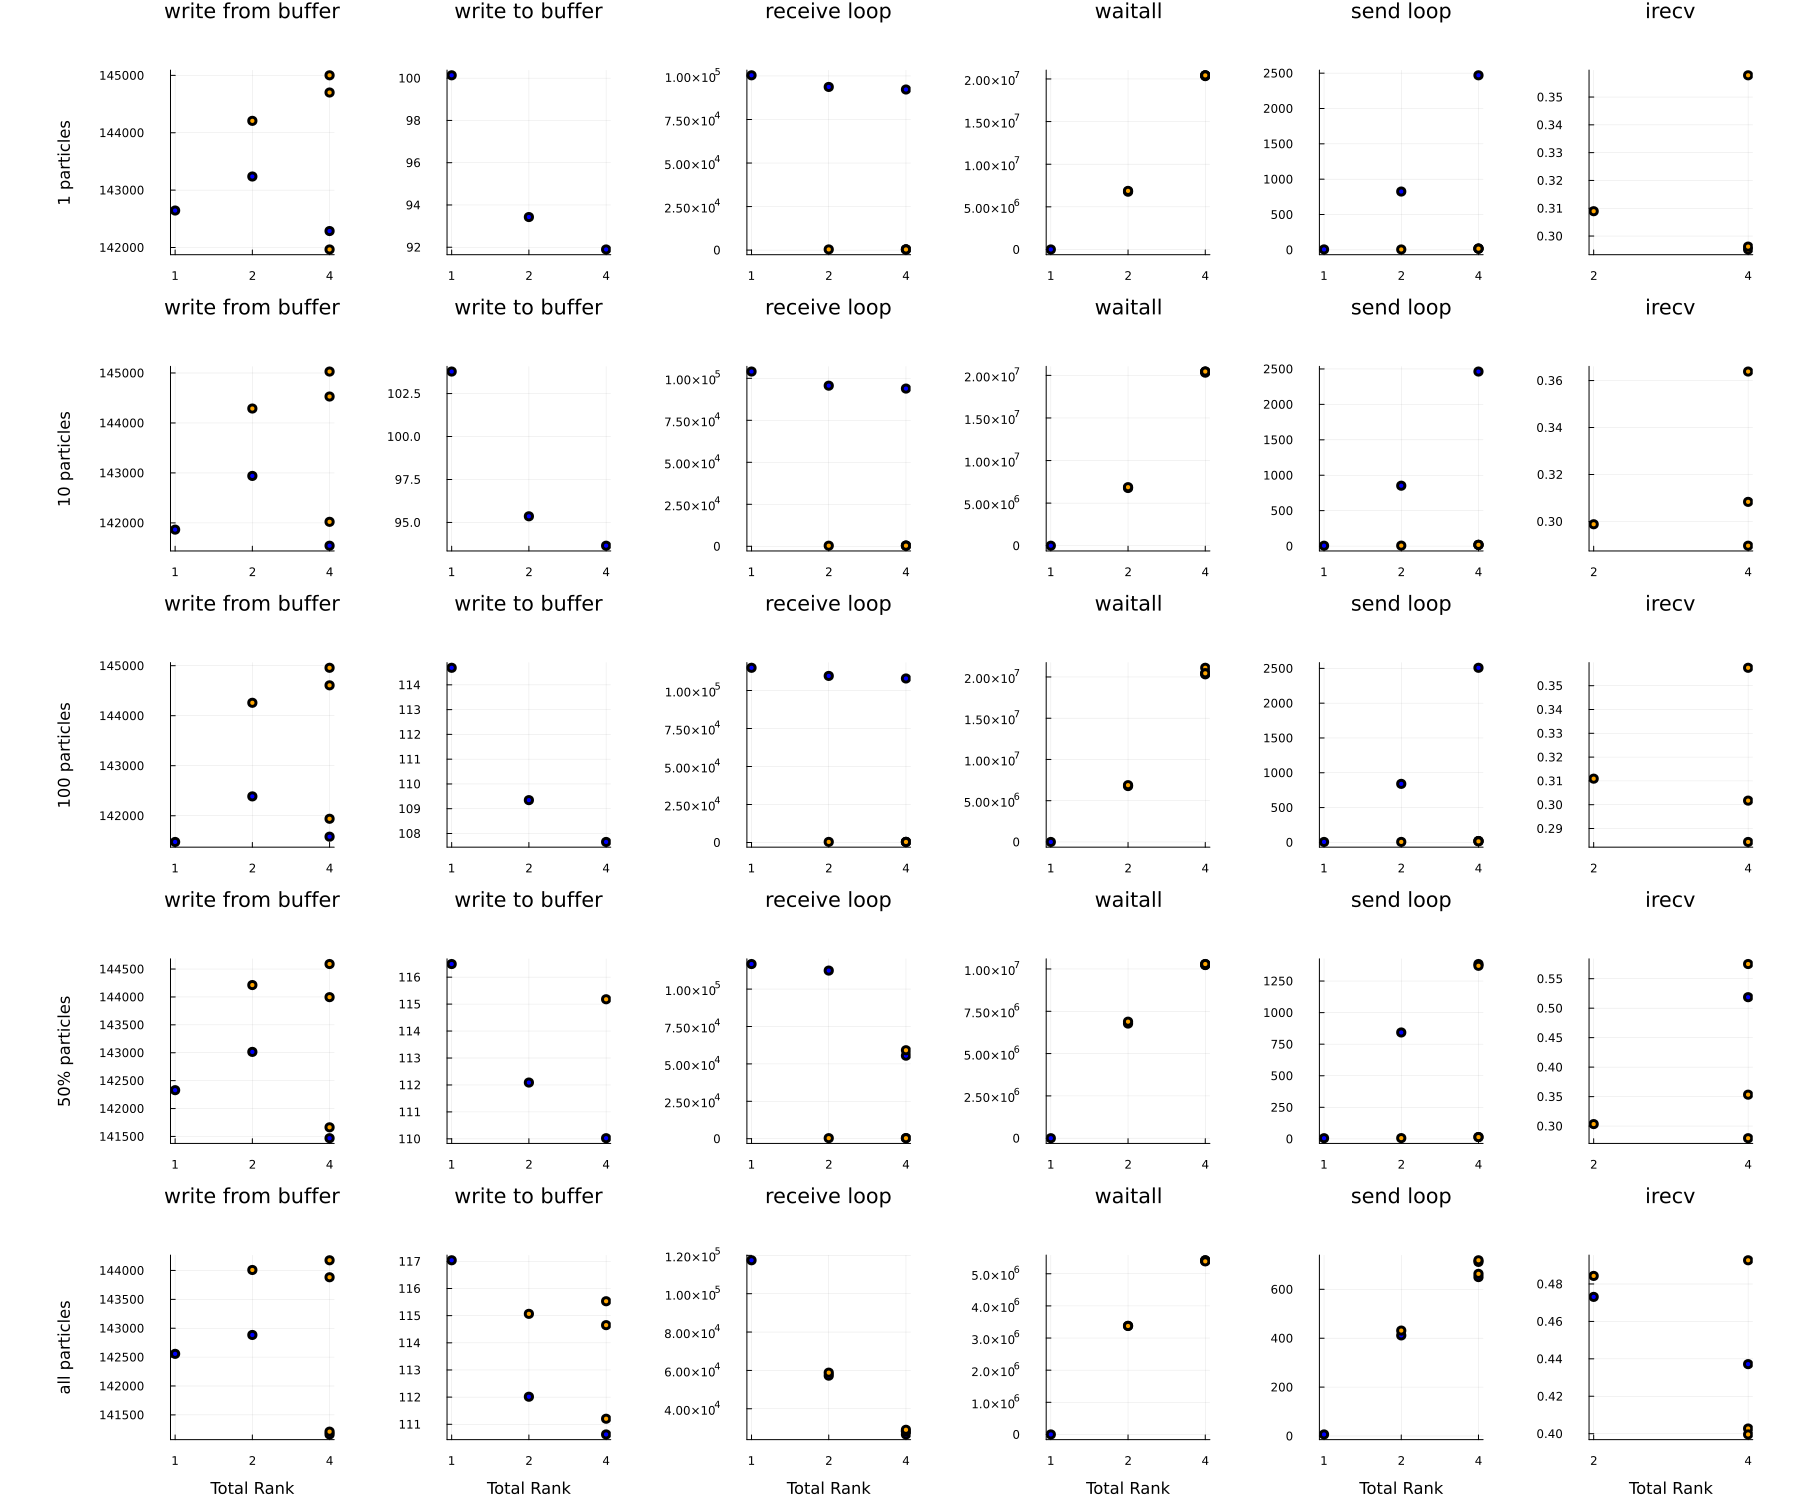

Picking particles randomly


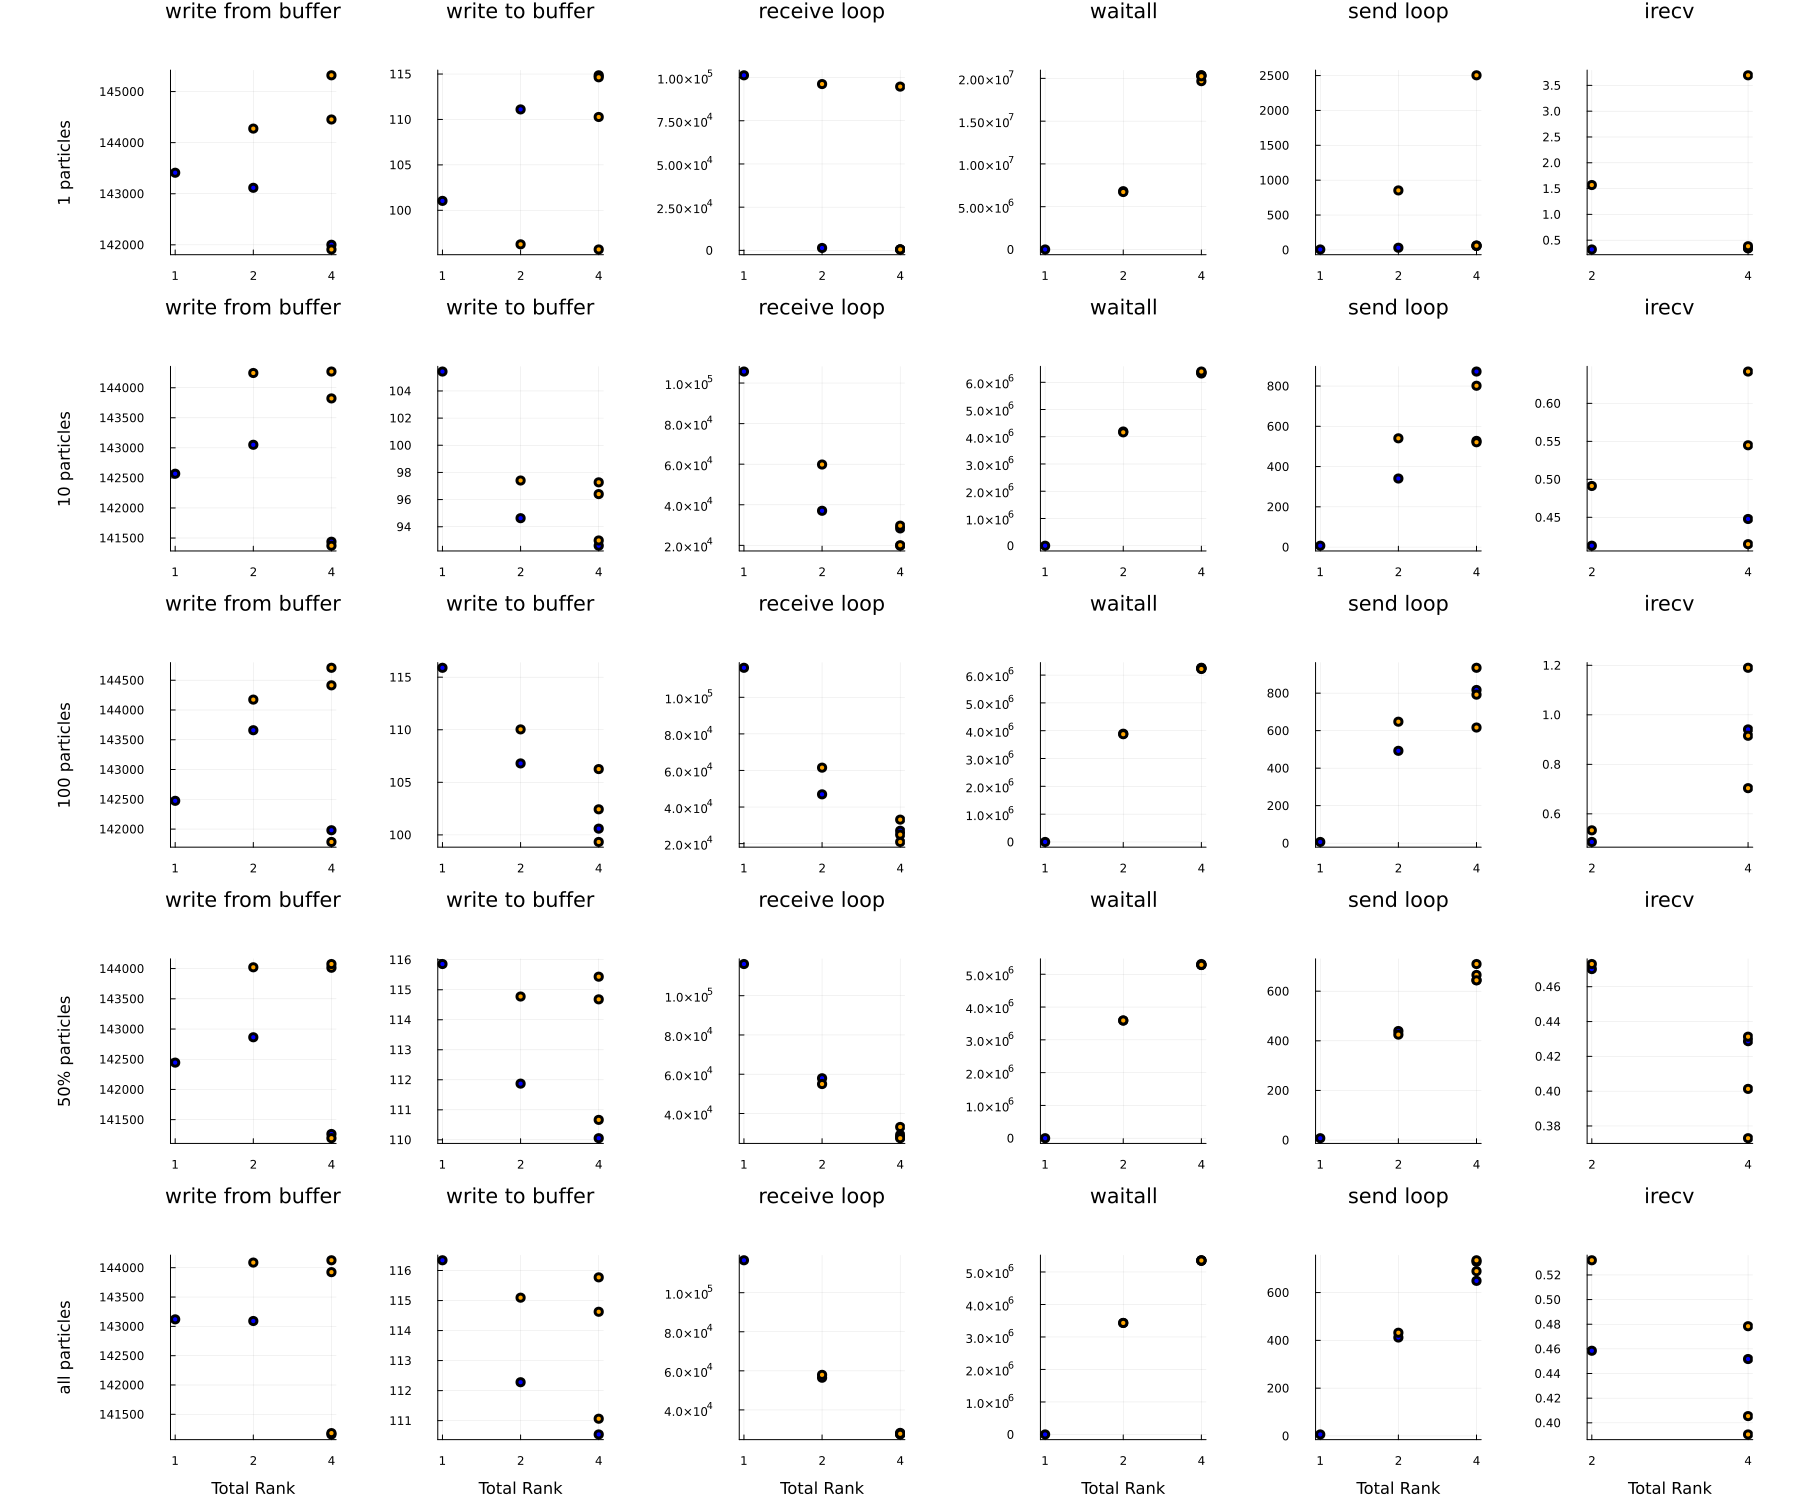

"/Users/sunchenge/Desktop/UCL/masterproj/ParticleDA.jl/extra/randperm_plot.png"

In [12]:
root = dirname(@__FILE__)
h5path(rank) = joinpath(root, "../test/output", "all_timers_$(rank).h5") 

all_timer_dfs = DataFrame()
for rank in [1, 2, 4]
    blob = h5open(h5path(rank)) do f
        read(f, "all_timers")
    end

    # Deserialize back into Dict{String,Dict{Int,Dict{String,Any}}}
    merged_timers = deserialize(IOBuffer(blob))

    # Convert to DataFrame
    timer_df = timer_dict_to_df(merged_timers)
    
    # Concat to all_timer_dfs
    all_timer_dfs = vcat(all_timer_dfs, timer_df)
end

wide = unstack(
  all_timer_dfs,
  [:trial, :perm, :total_rank, :nprt_per_rank, :particle_size, :rank, :op],
  :metric,
  :value
)

# Compute the average time per call
wide.time_micros .= wide.time_micros ./ wide.n_calls
# Sort by perm and trial
wide = sort!(wide, [:perm, :trial])

first_df = wide[wide.perm .== "firstperm", :]
rand_df = wide[wide.perm .== "randperm", :]

println("Picking particles from the beginning")
savefig(render(first_df), joinpath(root, "firstperm_plot.png"))
println("Picking particles randomly")
savefig(render(rand_df), joinpath(root, "randperm_plot.png"))
